In [1]:
import os
import cv2
import numpy as np

# Function to load images and corresponding masks
def load_data(data_dir, img_size=(512, 512)):
    images = []
    masks = []
    
    for img_file in os.listdir(data_dir):
        if img_file.endswith(".jpg"):  # Process only JPG files as images
            # Load image
            img_path = os.path.join(data_dir, img_file)
#             print(f"Processing Image: {img_file}")
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            images.append(img)
            
            # Construct the mask file name by appending '_mask.png' to the base filename
            mask_file = img_file.replace(".jpg", "_mask.png")
            mask_path = os.path.join(data_dir, mask_file)
            
            # Check if mask exists and load it
            if os.path.exists(mask_path):
#                 print(f"Mask found: {mask_file}")
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, img_size)
                masks.append(mask)
            else:
                print(f"Mask not found for {img_file}. Expected mask file: {mask_file}")
    
    images = np.array(images)
    masks = np.array(masks)
    
    return images, masks

# Function to preprocess masks for one-hot encoding
def preprocess_masks(masks, n_classes=5):  # Expect 5 classes now
    # Print unique pixel values in the masks for debugging
    unique_values = np.unique(masks)
    print("Unique pixel values in the masks before merging:", unique_values)
    
    # Merge pixel value 1 (background) with pixel value 0 (background)
    masks[masks == 1] = 0  # Map pixel value 1 to 0, so both represent background
    
    # If pixel value 5 should not be there, remap or merge it with background (optional)
    masks[masks == 5] = 0  # If you don't want to keep pixel value 5, merge it with background
    
    # Print unique pixel values in the masks after merging
    unique_values_after_merge = np.unique(masks)
    print("Unique pixel values in the masks after merging:", unique_values_after_merge)
    
    # Ensure the mask values are within the range of 0 to n_classes-1
    masks = np.clip(masks, 0, n_classes-1)  # Clip mask values to be within the valid range
    
    # One-hot encode masks (convert each pixel to a one-hot vector representing the class)
    masks = np.eye(n_classes)[masks]  # Convert the integer class masks into one-hot
    return masks

# Load train, valid, and test datasets
train_dir = r"C:\Users\LAXMI\Downloads\cap.v1i.png-mask-semantic1\train"
valid_dir = r"C:\Users\LAXMI\Downloads\cap.v1i.png-mask-semantic1\valid"
test_dir = r"C:\Users\LAXMI\Downloads\cap.v1i.png-mask-semantic1\test"

train_images, train_masks = load_data(train_dir)
valid_images, valid_masks = load_data(valid_dir)
test_images, test_masks = load_data(test_dir)

# Preprocess masks to one-hot encoding (expecting 5 classes)
train_masks = preprocess_masks(train_masks)
valid_masks = preprocess_masks(valid_masks)
test_masks = preprocess_masks(test_masks)

# Check the shape of the data loaded
print("Train images shape:", train_images.shape)
print("Train masks shape (after one-hot):", train_masks.shape)
print("Valid images shape:", valid_images.shape)
print("Valid masks shape (after one-hot):", valid_masks.shape)
print("Test images shape:", test_images.shape)
print("Test masks shape (after one-hot):", test_masks.shape)

Unique pixel values in the masks before merging: [0 1 2 3 4 5]
Unique pixel values in the masks after merging: [0 2 3 4]
Unique pixel values in the masks before merging: [0 1 2 3 4 5]
Unique pixel values in the masks after merging: [0 2 3 4]
Unique pixel values in the masks before merging: [0 1 2 3 4 5]
Unique pixel values in the masks after merging: [0 2 3 4]
Train images shape: (184, 512, 512, 3)
Train masks shape (after one-hot): (184, 512, 512, 5)
Valid images shape: (53, 512, 512, 3)
Valid masks shape (after one-hot): (53, 512, 512, 5)
Test images shape: (26, 512, 512, 3)
Test masks shape (after one-hot): (26, 512, 512, 5)


Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 4774s 77s/step - accuracy: 0.8294 - loss: 0.6266 - val_accuracy: 0.8971 - val_loss: 0.7013
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 3905s 63s/step - accuracy: 0.8997 - loss: 0.3343 - val_accuracy: 0.9006 - val_loss: 0.3993
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 5047s 82s/step - accuracy: 0.9132 - loss: 0.2782 - val_accuracy: 0.9035 - val_loss: 0.3203
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 5134s 83s/step - accuracy: 0.9302 - loss: 0.2277 - val_accuracy: 0.9083 - val_loss: 0.3239
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 4726s 76s/step - accuracy: 0.9369 - loss: 0.2043 - val_accuracy: 0.9200 - val_loss: 0.2824


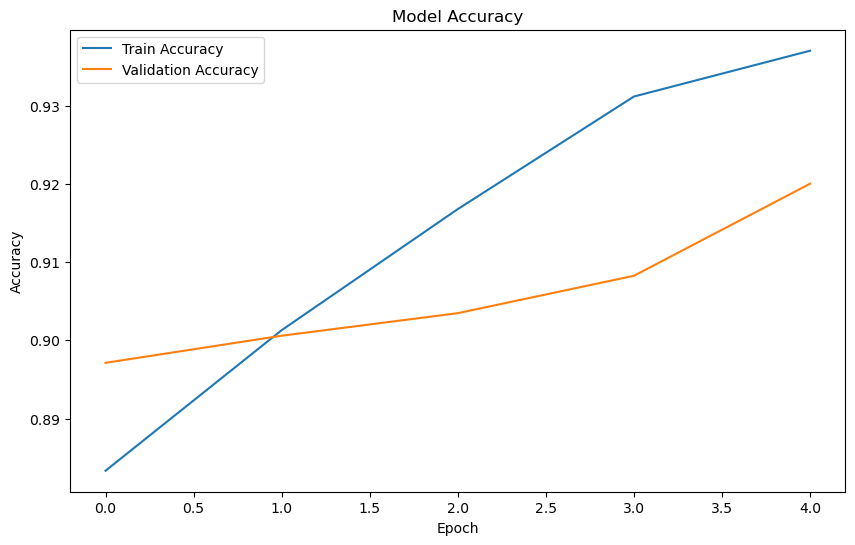

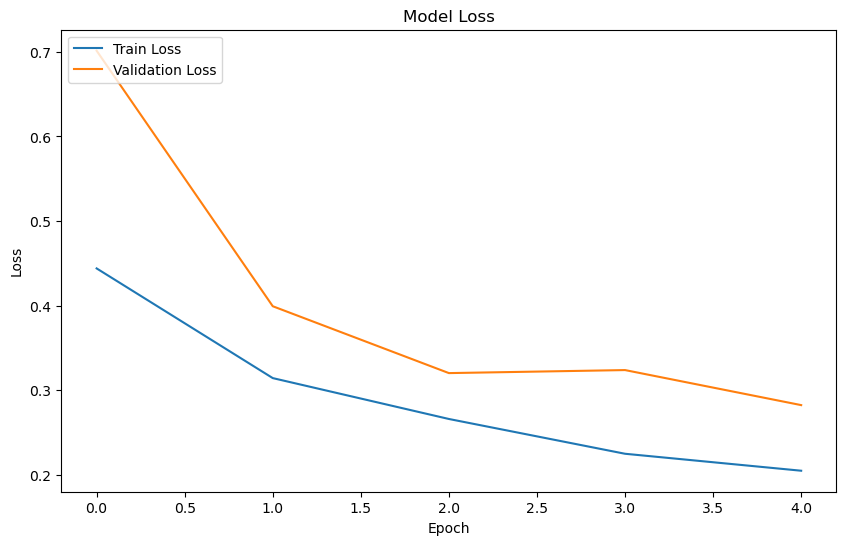

1/1 ━━━━━━━━━━━━━━━━━━━━ 87s 87s/step - accuracy: 0.9281 - loss: 0.2459
Test Loss: 0.24593287706375122, Test Accuracy: 0.9280529022216797


In [2]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, UpSampling2D, concatenate, Add, multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# --- MBNet Architecture ---
def conv_bn_act(inputs, n_filters=64, kernel=(3, 3), strides=1, activation='relu'):
    conv = Conv2D(n_filters, kernel_size=kernel, strides=strides, padding='same')(inputs)
    conv = BatchNormalization()(conv)
    conv = Activation(activation)(conv)
    return conv

def FeatureFusionModule(input_f, input_s, n_filters):
    concatenate_layer = concatenate([input_f, input_s])
    
    branch_1 = conv_bn_act(concatenate_layer, n_filters=n_filters, kernel=(3, 3), strides=1)
    branch_2 = conv_bn_act(branch_1, n_filters=n_filters, kernel=(1, 1), strides=1, activation='sigmoid')

    x = multiply([branch_1, branch_2])
    return Add()([branch_1, x])

def semantic_segmentation_branch(inputs, img_size=(512, 512)):
    # U-Net like encoder-decoder architecture for segmentation
    conv1 = conv_bn_act(inputs, 64, strides=1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_bn_act(pool1, 128, strides=1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_bn_act(pool2, 256, strides=1)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_bn_act(pool3, 512, strides=1)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = conv_bn_act(pool4, 1024, strides=1)
    
    # Upsampling path
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Conv2D(512, (2, 2), activation='relu', padding='same')(up6)
    merge6 = concatenate([conv4, up6], axis=3)
    
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, (2, 2), activation='relu', padding='same')(up7)
    merge7 = concatenate([conv3, up7], axis=3)

    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(128, (2, 2), activation='relu', padding='same')(up8)
    merge8 = concatenate([conv2, up8], axis=3)

    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(64, (2, 2), activation='relu', padding='same')(up9)
    merge9 = concatenate([conv1, up9], axis=3)

    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    out_segmentation = Conv2D(5, (1, 1), activation='softmax')(conv9)  # Assuming 5 classes
    return out_segmentation

# Build MBNet Model
def get_MBNet(img_size=(512, 512)):
    inputs = Input((img_size[0], img_size[1], 3))
    seg_output = semantic_segmentation_branch(inputs)

    model = Model(inputs=inputs, outputs=seg_output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

# --- Training Function ---
def train_MBNet(train_images, train_masks, valid_images, valid_masks, epochs=5, batch_size=3):
    model = get_MBNet(img_size=(512, 512))

    # Save the best model (Corrected indentation)
    model_checkpoint = ModelCheckpoint('MBNet_best_weights.keras', monitor='val_loss', save_best_only=True, mode='min')

    # Train the model
    history = model.fit(train_images, train_masks,
                        validation_data=(valid_images, valid_masks),
                        epochs=epochs, batch_size=batch_size,
                        callbacks=[model_checkpoint])

    return model, history

# --- Plot Training Curves ---
def plot_training_curves(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.savefig('accuracy_curve.png')
    plt.show()

    # Plot training & validation loss values
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.savefig('loss_curve.png')
    plt.show()

# --- Evaluate Model on Test Data ---
def evaluate_MBNet(model, test_images, test_masks):
    test_loss, test_accuracy = model.evaluate(test_images, test_masks)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# --- Example Usage ---
 
# Assuming train_images, train_masks, valid_images, valid_masks, test_images, and test_masks are already loaded and preprocessed
# Example:
model, history = train_MBNet(train_images, train_masks, valid_images, valid_masks, epochs=5, batch_size=3)
plot_training_curves(history)  

# Evaluate the model on test data
evaluate_MBNet(model, test_images, test_masks)







In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Function to predict and visualize the segmentation output
def predict_and_visualize_segmentation(model, image):
    # Predict the segmentation mask
    predicted_mask = model.predict(image[np.newaxis, ...])[0]  # Add batch dimension

    # Take the argmax to convert softmax output to class labels (0, 1, 2, 3, 4, etc.)
    predicted_mask = np.argmax(predicted_mask, axis=-1)

    # Define colors for each class (background, lumbar, sacrum, etc.)
    class_colors = {
        0: [0, 0, 0],         # Black for background
        1: [255, 0, 0],       # Red for lumbar
        2: [0, 255, 0],       # Green for sacrum
        3: [0, 0, 255],       # Blue for femoral1
        4: [0, 255, 255]      # Cyan for femoral2
    }

    # Create an empty RGB image to visualize the segmentation mask
    segmentation_visual = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)

    # Fill the RGB image with the corresponding class colors
    for class_id, color in class_colors.items():
        segmentation_visual[predicted_mask == class_id] = color

    # Show the predicted segmentation mask
    plt.imshow(segmentation_visual)
    plt.title("Predicted Segmentation Mask")
    plt.axis('off')
    plt.show()

# Example usage
# Assuming test_image is a single test image of shape (512, 512, 3)
predict_and_visualize_segmentation(model, test_image)


NameError: name 'test_image' is not defined

In [11]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Inspected values branch for predicting clinical values (e.g., PI, PT, SS)
def inspected_values_branch(inputs):
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    flatten = Flatten()(pool3)

    # Fully connected layers to predict the clinical values (regression)
    fc1 = Dense(1024, activation='relu')(flatten)
    fc2 = Dense(1024, activation='relu')(fc1)
    
    # Output 3 clinical values (PI, PT, SS)
    output_regression = Dense(3, activation='linear', name="regression_output")(fc2)

    return output_regression

# Check if the regression branch is created properly
dummy_input = np.random.rand(1, 512, 512, 64)  # Example input (512x512 image with 64 channels)
print(f"Dummy Input Shape: {dummy_input.shape}")


Dummy Input Shape: (1, 512, 512, 64)


In [ ]:
from tensorflow.keras.models import Model

# Build MBNet Model combining segmentation and regression branches
def get_MBNet_with_regression(img_size=(512, 512)):
    inputs = Input((img_size[0], img_size[1], 3))

    # Semantic segmentation branch
    seg_output = semantic_segmentation_branch(inputs)  # Already completed semantic segmentation branch
    
    # Inspected values branch (using the output of the segmentation)
    regression_output = inspected_values_branch(seg_output)

    # Define the full model with both segmentation and regression
    model = Model(inputs=inputs, outputs=[seg_output, regression_output])

    # Compile the model with loss functions for both tasks (segmentation and regression)
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss={"regression_output": "mse", "segmentation_output": "categorical_crossentropy"},
                  loss_weights={"regression_output": 0.1, "segmentation_output": 0.9},
                  metrics={"regression_output": "mae", "segmentation_output": "accuracy"})

    return model

# Check if the full MBNet model is built correctly
model = get_MBNet_with_regression(img_size=(512, 512))
model.summary()  # This will display the model structure and parameters


In [13]:
# Function to train the MBNet model with both segmentation and regression
def train_MBNet_with_regression(train_images, train_masks, train_regression_values, valid_images, valid_masks, valid_regression_values, epochs=50, batch_size=8):
    model = get_MBNet_with_regression(img_size=(512, 512))

    # Save the best model
    model_checkpoint = ModelCheckpoint('MBNet_best_weights_with_regression.keras', monitor='val_loss', save_best_only=True, mode='min')

    # Train the model
    history = model.fit(train_images, 
                        {"segmentation_output": train_masks, "regression_output": train_regression_values},
                        validation_data=(valid_images, 
                                         {"segmentation_output": valid_masks, "regression_output": valid_regression_values}),
                        epochs=epochs, batch_size=batch_size,
                        callbacks=[model_checkpoint])

    return model, history

# Example usage of training the model
model, history = train_MBNet_with_regression(train_images, train_masks, train_regression_values, 
                                             valid_images, valid_masks, valid_regression_values, 
                                             epochs=5, batch_size=3)

# Check if training history has been recorded properly
print(history.history.keys())  # This will show the metrics being tracked during training


NameError: name 'train_regression_values' is not defined

In [10]:
# Function to evaluate the MBNet model
def evaluate_MBNet_with_regression(model, test_images, test_masks, test_regression_values):
    test_loss, test_segmentation_acc, test_regression_mae = model.evaluate(test_images, 
                                                                           {"segmentation_output": test_masks, "regression_output": test_regression_values})
    print(f"Test Loss: {test_loss}, Test Segmentation Accuracy: {test_segmentation_acc}, Test Regression MAE: {test_regression_mae}")


In [14]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Regression branch for predicting PI, PT, and SS
def regression_branch(inputs):
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    flatten = Flatten()(pool2)

    fc1 = Dense(512, activation='relu')(flatten)
    fc2 = Dense(256, activation='relu')(fc1)
    
    # Output 3 clinical values (PI, PT, SS)
    output_regression = Dense(3, activation='linear', name="regression_output")(fc2)

    return output_regression

# Example of integrating the regression branch into the MBNet
def build_mbnet_with_regression(input_shape=(512, 512, 3)):
    inputs = Input(shape=input_shape)

    # Add your segmentation model here (e.g., feature extraction layers)
    feature_extraction = Conv2D(64, (3, 3), activation='relu')(inputs)
    feature_extraction = MaxPooling2D((2, 2))(feature_extraction)

    # Add regression branch for predicting PI, PT, SS
    regression_output = regression_branch(feature_extraction)

    # Create model
    model = Model(inputs=inputs, outputs=regression_output)

    # Compile model for regression
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

# Example usage
model = build_mbnet_with_regression()
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 512, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 510, 510, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 255, 255, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 255, 255, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 127, 127, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 254016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │     130,056,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ regression_output (Dense)            │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,227,555 (496.78 MB)

 Trainable params: 130,227,555 (496.78 MB)

 Non-trainable params: 0 (0.00 B)